Parte 5

En primer lugar se hará un implementación por semanas buscando comportamientos homogéneos y heterogéneos.
Posteriormente se aplicará el caso heterogéneos para una segmentación distinta, con el fin de evaluar otros resultados, siendo un caso interesante ver si alguno de los atributos marcará alguna relación con la probabilidad de estar satisfecho.

In [210]:
import pandas as pd 

df = pd.read_csv('./supermarket_sales.csv')
#df.head()

In [211]:
df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y")
df['week'] = df['Date'].dt.isocalendar()['week']
#df.head(10)

In [212]:
df.sort_values('week',inplace=True)
#df.head(10)

In [213]:
df['Satis'] = (df['Rating'] >= 7).astype(int)
df.head()

Invoice ID Branch       City Customer type  Gender         Product line  \
0    750-67-8428      A     Yangon        Member  Female    Health and beauty   
501  573-98-8548      C  Naypyitaw        Member  Female  Fashion accessories   
205  749-24-1565      A     Yangon        Normal  Female    Health and beauty   
837  670-71-7306      B   Mandalay        Normal    Male    Sports and travel   
271  687-15-1097      C  Naypyitaw        Member  Female    Health and beauty   

     Unit price  Quantity   Tax 5%     Total       Date   Time      Payment  \
0         74.69         7  26.1415  548.9715 2019-01-05  13:08      Ewallet   
501       31.90         1   1.5950   33.4950 2019-01-05  12:40      Ewallet   
205       23.03         9  10.3635  217.6335 2019-01-03  12:02      Ewallet   
837       44.63         6  13.3890  281.1690 2019-01-02  20:08  Credit card   
271       21.12         2   2.1120   44.3520 2019-01-03  19:17         Cash   

       cogs  gross margin percentage  gross income  Rating  week  Satis  
0    522.83                 4.761905       26.1415     9.1     1      1  
501   31.90                 4.761905        1.5950     9.1     1      1  
205  207.27                 4.761905       10.3635     7.9     1      1  
837  267.78                 4.761905       13.3890     5.1     1      0  
271   42.24                 4.761905        2.1120     9.7     1      1

In [214]:

gb = df[['Rating', 'week','Satis']].groupby('week')
mean_satis = gb.sum()['Satis']
count = gb.count()
count['Satis'] = mean_satis
count['Frac'] = mean_satis/count['Rating']
count

Rating  Satis      Frac
week                         
1         55     29  0.527273
2         73     32  0.438356
3         82     45  0.548780
4         93     51  0.548387
5         83     37  0.445783
6         92     53  0.576087
7         72     37  0.513889
8         60     36  0.600000
9         87     36  0.413793
10        88     49  0.556818
11        78     29  0.371795
12        76     37  0.486842
13        61     30  0.491803

En primer lugar se probará un modelo completamente homogéneo, donde se estimará solamente a partir de los parámetros poblacional de los 3 Branch en forma combinada.

El modelo quedaría, con $N_t=Rating$, $x_t=Satis$ y prob de quedar satisfecho $\theta$:

$$
\mathbb{P}(x_t = k_t) =  {N_t\choose k_t} \theta^k_t(1-\theta)^{N_t - k_t}
$$

Likelihood:

$$
l(\theta) = log(f(\{x_t\}_{t=1}^{13}|\theta)) = \sum_{t=1}^{13} log({N_t\choose k_t} \theta^k(1-\theta)^{N_t - k_t}) =  \sum_{t=1}^{13} log({N_t\choose k_t}) + k_tlog(\theta) + (N_t - k_t) log(1-\theta)
$$



In [219]:
import numpy as np
from scipy.optimize import minimize

# sub_count de train
sub_count = count.iloc[:7,:]
print(sub_count)

# Valor inicial
θ = 0.1
N_t = sub_count['Rating']
k =   sub_count['Satis']

# Log-likelyhood
# ll_array = k*np.log(θ) + (N_t - k)*np.log(1-θ)

def ll(θ):
    return -np.sum(k*np.log(θ) + (N_t - k)*np.log(1-θ))

res = minimize(ll, θ, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

print()
print('θ óptimo:',res.x[0])

      Rating  Satis      Frac
week                         
1         55     29  0.527273
2         73     32  0.438356
3         82     45  0.548780
4         93     51  0.548387
5         83     37  0.445783
6         92     53  0.576087
7         72     37  0.513889
Optimization terminated successfully.
         Current function value: 380.936351
         Iterations: 31
         Function evaluations: 62

θ óptimo: 0.5163636398315443


In [9]:
θ = res.x[0] # óptimo

# Agrego predicción de prob 
count['Pred_Frac'] = θ # Prob predicha
count

Rating  Satis      Frac  Pred_Frac
week                                    
1         55     29  0.527273   0.516364
2         73     32  0.438356   0.516364
3         82     45  0.548780   0.516364
4         93     51  0.548387   0.516364
5         83     37  0.445783   0.516364
6         92     53  0.576087   0.516364
7         72     37  0.513889   0.516364
8         60     36  0.600000   0.516364
9         87     36  0.413793   0.516364
10        88     49  0.556818   0.516364
11        78     29  0.371795   0.516364
12        76     37  0.486842   0.516364
13        61     30  0.491803   0.516364

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


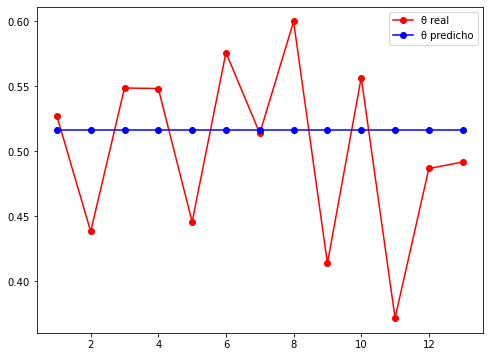

In [10]:
import matplotlib.pyplot as plt 

# Proporción solamente (theta)
x = [t for t in range(1,13 +1)]
print(x)
y1,y2 = count['Frac'], count['Pred_Frac']
plt.figure(figsize=(8,6))
plt.plot(x, y1, '-o',c='red' , label='θ real')
plt.plot(x, y2, '-o',c='blue', label='θ predicho')
plt.legend()
plt.show()

      Rating  Satis      Frac  Pred_Frac     Pred_Prob          Prob
week                                                                
1         55     29  0.527273   0.516364  2.973079e-17  3.012320e-17
2         73     32  0.438356   0.516364  7.583289e-23  1.846582e-22
3         82     45  0.548780   0.516364  2.571611e-25  3.056969e-25
4         93     51  0.548387   0.516364  1.289834e-28  1.561834e-28
5         83     37  0.445783   0.516364  7.365981e-26  1.685941e-25
6         92     53  0.576087   0.516364  3.040104e-28  5.883837e-28
7         72     37  0.513889   0.516364  2.175315e-22  2.177236e-22
8         60     36  0.600000   0.516364  1.244108e-18  2.903252e-18
9         87     36  0.413793   0.516364  3.774589e-27  2.370249e-26
10        88     49  0.556818   0.516364  4.276277e-27  5.710215e-27
11        78     29  0.371795   0.516364  1.648702e-24  4.423549e-23
12        76     37  0.486842   0.516364  1.190140e-23  1.358784e-23
13        61     30  0.491803   0.

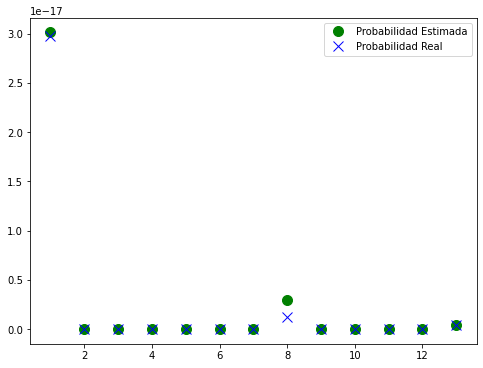

In [11]:
# probabilidades

# Completo
N_t = count['Rating']
k =   count['Satis']

# Predicha 
count['Pred_Prob'] = θ**k * (1-θ)**(N_t-k)

# Real
θ = count['Frac']
count['Prob'] =      θ**k * (1-θ)**(N_t-k)  

print(count)

# Distribución
y1,y2 = count['Prob'], count['Pred_Prob']
plt.figure(figsize=(8,6))
plt.plot(x, y1, 'o', c='green', markersize=10, label='Probabilidad Estimada')
plt.plot(x, y2, 'x', c='blue' , markersize=10, label='Probabilidad Real')
plt.legend()
plt.show()

## Homogéneo - Separando por tienda

In [12]:

gb = df[['Rating','Branch', 'week','Satis']].groupby(['Branch','week'])
mean_satis = gb.sum()['Satis']
count = gb.count()
count['Satis'] = mean_satis
count['Frac'] = mean_satis/count['Rating']
count

Rating  Satis      Frac
Branch week                         
A      1         22     10  0.454545
       2         24     11  0.458333
       3         29     15  0.517241
       4         33     21  0.636364
       5         23     10  0.434783
       6         27     15  0.555556
       7         23     16  0.695652
       8         17      9  0.529412
       9         26      7  0.269231
       10        34     21  0.617647
       11        22     10  0.454545
       12        33     19  0.575758
       13        27     15  0.555556
B      1         18      8  0.444444
       2         23      9  0.391304
       3         24     13  0.541667
       4         28     14  0.500000
       5         27     12  0.444444
       6         32     18  0.562500
       7         24     10  0.416667
       8         22     11  0.500000
       9         39     17  0.435897
       10        29     16  0.551724
       11        29      9  0.310345
       12        20      6  0.300000
       13        17      8  0.470588
C      1         15     11  0.733333
       2         26     12  0.461538
       3         29     17  0.586207
       4         32     16  0.500000
       5         33     15  0.454545
       6         33     20  0.606061
       7         25     11  0.440000
       8         21     16  0.761905
       9         22     12  0.545455
       10        25     12  0.480000
       11        27     10  0.370370
       12        23     12  0.521739
       13        17      7  0.411765

Ahora tendremos un modelo homogéneo por tiendas. Es decir, la prob de que 1 cliente quede satisfecho es:

$$
    \theta_1 frac_A+\theta_2 frac_B + \theta_3 frac_C
$$

Luego la log-like:

$$
    l(\theta) = log(f(\{x_t\}_{t=1}^{13}|\theta)) = \sum_{t=1}^{13} log(\prod_{q\in\{A,B,C\}}\theta_q^{Satis_q}(1-\theta_q)^{Total_q - Satis_q}) =  \sum_{t=1}^{13} \sum_{q\in\{A,B,C\}} Satis_qlog(\theta_q) + (Total_q - Satis_q) log(1-\theta_q)
$$

In [13]:
import numpy as np
from scipy.optimize import minimize

# sub_counts de train (para c/u)
sub_count1 = count.iloc[:7,:]
print(sub_count1)
sub_count2 = count.iloc[13:20,:]
print(sub_count2)
sub_count3 = count.iloc[26:33,:]
print(sub_count3)

# Valores iniciales
θ = [0.1, 0.1, 0.1]

# Sub_counts datos
N_t = [sub_count1['Rating'],sub_count2['Rating'] ,sub_count3['Rating']]
k   = [sub_count1['Satis'],sub_count2['Satis'] ,sub_count3['Satis']]

# Log-likelyhood
# ll_array = k*np.log(θ) + (N_t - k)*np.log(1-θ)

def ll_q(θ):
    return -np.sum( np.sum([k[q]*np.log(θ[q]) + (N_t[q] - k[q])*np.log(1-θ[q]) for q in [0,1,2]]) )

res = minimize(ll_q, θ, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

for q in [0,1,2]:
    print()
    print(f'θ óptimo para {q}:',res.x[q])

             Rating  Satis      Frac
Branch week                         
A      1         22     10  0.454545
       2         24     11  0.458333
       3         29     15  0.517241
       4         33     21  0.636364
       5         23     10  0.434783
       6         27     15  0.555556
       7         23     16  0.695652
             Rating  Satis      Frac
Branch week                         
B      1         18      8  0.444444
       2         23      9  0.391304
       3         24     13  0.541667
       4         28     14  0.500000
       5         27     12  0.444444
       6         32     18  0.562500
       7         24     10  0.416667
             Rating  Satis      Frac
Branch week                         
C      1         15     11  0.733333
       2         26     12  0.461538
       3         29     17  0.586207
       4         32     16  0.500000
       5         33     15  0.454545
       6         33     20  0.606061
       7         25     11  0.440000
O

In [14]:
df.loc[df['Branch']=='C','Satis'].mean()

0.5213414634146342

Se observa que en el caso homogéneo obtenemos probabilidades asociadas a los distintos Branch. En este caso las estimaciones son muy simples, pues dependen únicamente de un parámetro $\theta$ asociado a una distribución Binomial. Es de esperar que este resultado se acerque a la media, pero no dice mucho respecto al comportamiento de esta probabilidad. Puede servir como un marco de referencia para tomar decisiones sencillas, donde en este caso se obtienen valores muy cercanos a 0.5, lo que muestra que hay poca certeza de si un cliente estaría satisfecho o no.

## Continuo con Beta Binomial

Se revisará primero una segmentación heterogénea considerando las semanas. Posteriormente se hará un análisis en que se supondrá independencia entre las semanas haciendo una segmentación por otros atributos, y utilizando las semanas como referencia de training.

El modelo quedaría, con $N_t=Rating$, $x_t=Satis$ y prob de quedar satisfecho $\theta \in (0,1)$ :

$$
\mathbb{P}(x_t = k|\theta, N_t) = \int_{0}^{1}\theta^k(1-\theta)^{N_t - k}g(\theta)d\theta
$$

Tomamos $\theta \sim Beta(\alpha, \beta)$:

$$
g(\theta) = \frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{B(\alpha, \beta)}
$$

Entonces:

$$
\mathbb{P}(x_t = k|\theta, N_t) = \int_{0}^{1}\theta^k(1-\theta)^{N_t - k}\frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{B(\alpha, \beta)}
d\theta
$$

$$
= {N_t \choose k_t}\frac{B(\alpha + k_t, \beta + N_t - k_t)}{B(\alpha, \beta)}
$$

Luego, la log-likelyhood:

$$
l(\theta) = log\bigg(\prod_{t=1}^{13}\mathbb{P}(x_t = k|\theta, N_t) \bigg) = \sum_{t=1}^{13}log\bigg({N_t \choose k_t}\bigg)+log\bigg(\frac{B(\alpha + k_t, \beta + N_t - k_t)}{B(\alpha, \beta)}\bigg) = \sum_{t=1}^{13}log\bigg({N_t \choose k_t}\bigg)+log\bigg(B(\alpha + k_t, \beta + N_t - k_t)\bigg)- log\bigg({B(\alpha, \beta)}\bigg) 
$$

Basta con maximizar entonces:

$$
 \sum_{t=1}^{13}log\bigg(B(\alpha + k_t, \beta + N_t - k_t)\bigg)- log\bigg({B(\alpha, \beta)}\bigg) 
$$





In [18]:
import numpy as np
from scipy.optimize import minimize

import scipy.special as sc # Beta sc.beta(alpha, beta)
from math import comb # Combinatoria

# sub_count de train
sub_count = count.iloc[:7,:]
print(sub_count)

# Valor inicial
α = 0.1
β = 0.1
N_t = sub_count['Rating']
k =   sub_count['Satis']

def ll_beta_binom(list_α_β):
    α = list_α_β[0]
    β = list_α_β[1]
    return -np.sum( [ np.log(sc.beta(α + k[t+1], β + N_t[t+1] - k[t+1])) - np.log(sc.beta(α, β)) for t in range(7)] )

res = minimize(ll_beta_binom, [α, β], method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

print()
print('α, β óptimos:',res.x)

      Rating  Satis      Frac
week                         
1         55     29  0.527273
2         73     32  0.438356
3         82     45  0.548780
4         93     51  0.548387
5         83     37  0.445783
6         92     53  0.576087
7         72     37  0.513889
Optimization terminated successfully.
         Current function value: 380.849856
         Iterations: 119
         Function evaluations: 241

α, β óptimos: [493.88636481 483.34361257]
<ipython-input-18-db3564ac92eb>:20: RuntimeWarning: divide by zero encountered in log
  return -np.sum( [ np.log(sc.beta(α + k[t+1], β + N_t[t+1] - k[t+1])) - np.log(sc.beta(α, β)) for t in range(7)] )
<ipython-input-18-db3564ac92eb>:20: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum( [ np.log(sc.beta(α + k[t+1], β + N_t[t+1] - k[t+1])) - np.log(sc.beta(α, β)) for t in range(7)] )


Se puede ver una distribución de $\theta$ muy concentrada en 0.5 y con valores altos de $\alpha$ y $\beta$, lo que indica que al momento de realizar estimaciones condicionales se confiará más en los parámetros generales del modelo, indicado que la segmentación no aporta mucho valor a la probabilidad

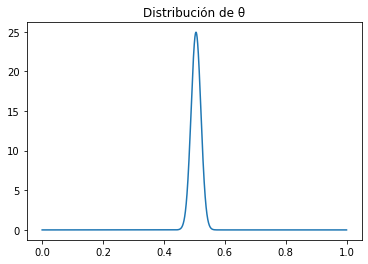

In [29]:
N = 100000
θ = np.linspace(0,1,N)
α, β = 493.88636481, 483.34361257
t = 2
g_θ = θ**(α-1)*(1-θ)**(β - 1)  / sc.beta(α, β)
plt.plot(θ, g_θ) 
plt.title('Distribución de θ')
plt.show()

A continuación se muestra un caso puntual de distribución condicional. En este caso vemos la distribución del número de clientes satisfechos para la semana 1 teniendo en cuenta los parámetros que se encontraron.

In [21]:
# N = 100000
# θ = np.linspace(0,1,N)
N_t = sub_count['Rating']
t = 1
k = [i for i in range(1,N_t[t]+1)]
α, β = 493.88636481, 483.34361257

p_xt = [comb(N_t[t], k[i]) * sc.beta(α + k[i], β + N_t[t] - k[i]) / sc.beta(α, β) for i in range(N_t[t])]
plt.plot(k, p_xt) 
plt.title('P(x_t|α, β)')
plt.show()

Hasta ahora, tanto en el modelo homogéneo como heterogéneo se encontraron estimaciones que indicarían una cercanía del parámetro $\theta$ a la probabilidad más incierta: 0.5. Esto muestra una dificultad de predicción respecto a la satisfacción de los clientes, donde hasta ahora no se ha logrado algo que mejore el panorama inicial asociado a la frecuencia empírica. A continuación se presentará un último modelo con una segmentación asociada a los atributos:

## Modelo Heterogéneo - Segmentación por atributos

Se hara un modelo para cada tienda, separando como segmento la combinación de las variables Gender y Product Line. Se eligen estas variables ya que se encontró un comportamiento interesante en la exploración de datos. Además, existe un trade-off al incluir una mayor segmentación con una muestra pequeña, donde si bien se podría estar ganando información, el tamaño de la muestra es cada vez menos confiable. Por estas razones, se optará solo por esta combinación en este ejercicio particular, pero es posible realizar otro tipo de segmentaciones para evaluar la satisfacción.


Se utilizará de referencia para los modelos las primeras 8 semanas, buscando testear en las 4 semanas restantes.
Para un segmento $s$ tendremos $N_s$ miembros, donde cada uno está satisfecho con probabilidad $\theta_s$. 
$X_s$: número total de clientes del segmento que están satisfecho distribuirá $Bin(N_s,\theta_s)$.

Para poder heterogenizar se considerará que el parámetro $\theta$ sigue una distribución $Beta(\alpha,\beta)$.



In [196]:
def segments(df,branch,var_seg):
    gb = df[df["Branch"]==branch][['Rating','Satis']+var_seg].groupby(var_seg)
    mean_satis = gb.sum()['Satis']
    count = gb.count()
    count['Satis'] = mean_satis
    count['Frac'] = mean_satis/count['Rating']
    return count

var_interes = ["Product line", "Gender"]

En cada caso se optimiza la función LL, donde lo que se busca es optimizar:
$$
log(\prod_{s \in S} \mathbb{P}(X_s = x_s|\theta, N_s)) 
$$
$$
= \sum log({N_t \choose k_t}\frac{B(\alpha + x_s, \beta + N_s - k_s)}{B(\alpha, \beta)})
$$


In [197]:
# Valor inicial
α = 0.1
β = 0.1
#N_s = segmentsA['Rating']
#x_s =   segmentsA['Satis']
N = segments(df,"A",var_interes)["Rating"].to_numpy()

def ll_beta_binom_2(params):

    # parámetros de la beta
    α = params[0]
    β = params[1]


    return -np.sum( [ np.log(sc.beta(α + x_s[s], β + N_s[s] - x_s[s])) - np.log(sc.beta(α, β)) for s in range(len(N))])

def min_ll():
    res = minimize(ll_beta_binom_2, [α, β], method='nelder-mead',
               options={'xatol': 1e-8, 'disp': False})
    return res.x


Definimos algunos plots que nos pueden ser útiles

In [198]:
def dist_θ(opt,branch):
    N = 100000
    θ = np.linspace(0,1,N)
    α, β = opt[0], opt[1]
    g_θ = θ**(α-1)*(1-θ)**(β - 1)  / sc.beta(α, β)
    plt.plot(θ, g_θ) 
    plt.title(f'Distribución de θ en Branch {branch}')
    plt.show()

def dist_θ_cond_x(opt,n,x,seg):
    N = 100000
    θ = np.linspace(0,1,N)
    α, β = opt[0], opt[1]
    g_θ = θ**(α+x-1)*(1-θ)**(β+n-x- 1)  / sc.beta(α+x, β+n-x)
    plt.plot(θ, g_θ) 
    plt.title(f'θ condicional a {seg}')
    plt.show()

Resultados, distribución de $\theta$ para cada branch, esta se construye a partir de los parámetros óptimos $\alpha$ y $\beta$ encontrados en cada modelo:

<ipython-input-197-504a2365c80f>:15: RuntimeWarning: divide by zero encountered in log
  return -np.sum( [ np.log(sc.beta(α + x_s[s], β + N_s[s] - x_s[s])) - np.log(sc.beta(α, β)) for s in range(len(N))])
<ipython-input-197-504a2365c80f>:15: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum( [ np.log(sc.beta(α + x_s[s], β + N_s[s] - x_s[s])) - np.log(sc.beta(α, β)) for s in range(len(N))])
<ipython-input-197-504a2365c80f>:15: RuntimeWarning: invalid value encountered in log
  return -np.sum( [ np.log(sc.beta(α + x_s[s], β + N_s[s] - x_s[s])) - np.log(sc.beta(α, β)) for s in range(len(N))])

α, β óptimos: [568.64025656 485.32814947]


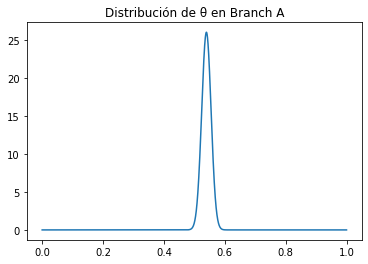

<ipython-input-197-504a2365c80f>:15: RuntimeWarning: divide by zero encountered in log
  return -np.sum( [ np.log(sc.beta(α + x_s[s], β + N_s[s] - x_s[s])) - np.log(sc.beta(α, β)) for s in range(len(N))])
<ipython-input-197-504a2365c80f>:15: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum( [ np.log(sc.beta(α + x_s[s], β + N_s[s] - x_s[s])) - np.log(sc.beta(α, β)) for s in range(len(N))])

α, β óptimos: [581.16272015 473.73441669]


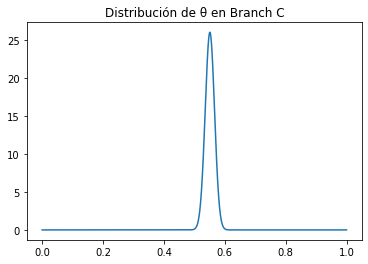

<ipython-input-197-504a2365c80f>:15: RuntimeWarning: divide by zero encountered in log
  return -np.sum( [ np.log(sc.beta(α + x_s[s], β + N_s[s] - x_s[s])) - np.log(sc.beta(α, β)) for s in range(len(N))])
<ipython-input-197-504a2365c80f>:15: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum( [ np.log(sc.beta(α + x_s[s], β + N_s[s] - x_s[s])) - np.log(sc.beta(α, β)) for s in range(len(N))])

α, β óptimos: [519.5564958  530.85191798]


In [199]:
opt_branch = {} # guadamos optimos alpha beta 
seg_branch = {} # guardamos la información de los segmentos
for b in df["Branch"].unique():
    seg_branch[b] = segments(df[df["week"]<=8],b,var_interes)
    s = seg_branch[b]
    α = 0.1
    β = 0.1
    N_s = s['Rating']
    x_s =   s['Satis']
    min_ll()
    opt = min_ll()
    print()
    print('α, β óptimos:',opt)
    dist_θ(opt,b)
    opt_branch[b] = opt



Ahora para el caso del Branch A, analizaremos las distribuciones condicionales en cada segmento 

**Branch A**

Segmento ('Electronic accessories', 'Female')
Esperanza condicional: 0.4933036773935559
Fracción real: 0.4117647058823529


------------------------
Segmento ('Electronic accessories', 'Male')
Esperanza condicional: 0.49799168300543906
Fracción real: 0.6842105263157895


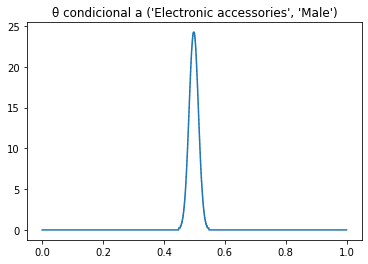

------------------------
Segmento ('Fashion accessories', 'Female')
Esperanza condicional: 0.49657944269345555
Fracción real: 0.625


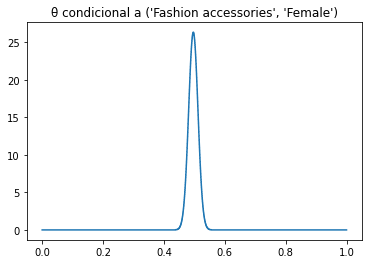

------------------------
Segmento ('Fashion accessories', 'Male')
Esperanza condicional: 0.4947039886233738
Fracción real: 0.5


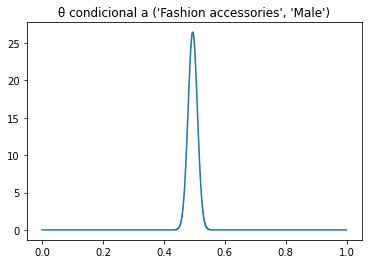

------------------------
Segmento ('Food and beverages', 'Female')
Esperanza condicional: 0.4951501127891215
Fracción real: 0.5454545454545454


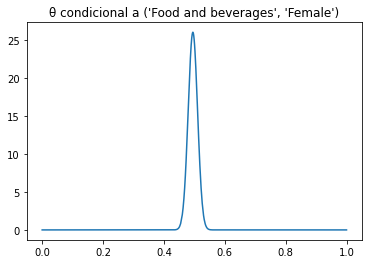

------------------------
Segmento ('Food and beverages', 'Male')
Esperanza condicional: 0.49799543193436047
Fracción real: 0.6666666666666666


------------------------
Segmento ('Health and beauty', 'Female')
Esperanza condicional: 0.4951501127891215
Fracción real: 0.5454545454545454


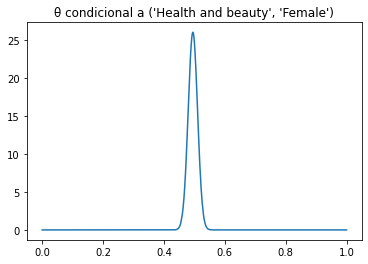

------------------------
Segmento ('Health and beauty', 'Male')
Esperanza condicional: 0.4960922571955666
Fracción real: 0.6363636363636364


------------------------
Segmento ('Home and lifestyle', 'Female')
Esperanza condicional: 0.4914460079295966
Fracción real: 0.3157894736842105


------------------------
Segmento ('Home and lifestyle', 'Male')
Esperanza condicional: 0.4961287301479362
Fracción real: 0.5714285714285714


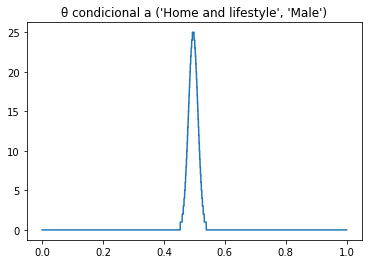

------------------------
Segmento ('Sports and travel', 'Female')
Esperanza condicional: 0.4956498741197022
Fracción real: 0.5555555555555556


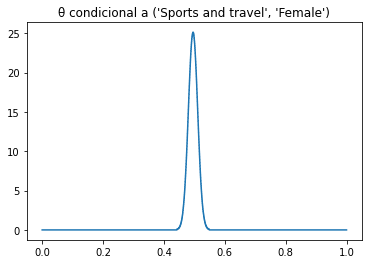

------------------------
Segmento ('Sports and travel', 'Male')
Esperanza condicional: 0.49377793079335086
Fracción real: 0.4444444444444444


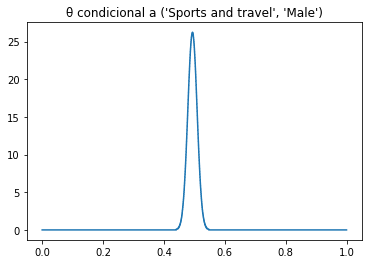

------------------------


In [200]:
E_cond_dic = {}
E_cond_dic["A"] = []
sA = seg_branch["A"]
for N_s,x_s,frac_s,index in zip(sA["Rating"],sA["Satis"],sA["Frac"],sA.index):
    alpha,beta=opt[0],opt[1]
    gamma = (alpha+beta)/(alpha+beta+N_s)
    E_cond = gamma*(alpha/(alpha+beta))+(1-gamma)*(x_s/N_s)
    E_cond_dic["A"].append(E_cond)
    print(f"Segmento {index}")
    print(f"Esperanza condicional: {E_cond}")
    print(f"Fracción real: {frac_s}")
    dist_θ_cond_x(opt,N_s,x_s,index)
    print("------------------------")

Para los Branch B y C, analizaremos solo la relación entre la fracción real de cada segmento y la esperanza condicional obtenida para el parámetro $\theta$.



**Branch B**

In [201]:
sB = seg_branch["B"]
E_cond_dic["B"] = []
for N_s,x_s,frac_s,index in zip(sB["Rating"],sB["Satis"],sB["Frac"],sB.index):
    alpha,beta=opt[0],opt[1]
    gamma = (alpha+beta)/(alpha+beta+N_s)
    E_cond = gamma*(alpha/(alpha+beta))+(1-gamma)*(x_s/N_s)
    E_cond_dic["B"].append(E_cond)
    print(f"Segmento {index}")
    print(f"Esperanza condicional: {E_cond}")
    print(f"Fracción real: {frac_s}")
    print("------------------------")

Segmento ('Electronic accessories', 'Female')
Esperanza condicional: 0.495168321345195
Fracción real: 0.5333333333333333
------------------------
Segmento ('Electronic accessories', 'Male')
Esperanza condicional: 0.4965858457828779
Fracción real: 0.6111111111111112
------------------------
Segmento ('Fashion accessories', 'Female')
Esperanza condicional: 0.49380113862770453
Fracción real: 0.45454545454545453
------------------------
Segmento ('Fashion accessories', 'Male')
Esperanza condicional: 0.4919059874669995
Fracción real: 0.3333333333333333
------------------------
Segmento ('Food and beverages', 'Female')
Esperanza condicional: 0.495195379254724
Fracción real: 0.5238095238095238
------------------------
Segmento ('Food and beverages', 'Male')
Esperanza condicional: 0.4942188617168692
Fracción real: 0.46153846153846156
------------------------
Segmento ('Health and beauty', 'Female')
Esperanza condicional: 0.4965665641911313
Fracción real: 0.6666666666666666
--------------------

**Branch C**

In [202]:
sC = seg_branch["C"]
E_cond_dic["C"] = []
for N_s,x_s,frac_s,index in zip(sC["Rating"],sC["Satis"],sC["Frac"],sC.index):
    alpha,beta=opt[0],opt[1]
    gamma = (alpha+beta)/(alpha+beta+N_s)
    E_cond = gamma*(alpha/(alpha+beta))+(1-gamma)*(x_s/N_s)
    E_cond_dic["C"].append(E_cond)
    print(f"Segmento {index}")
    print(f"Esperanza condicional: {E_cond}")
    print(f"Fracción real: {frac_s}")
    print("------------------------")

Segmento ('Electronic accessories', 'Female')
Esperanza condicional: 0.4947039886233738
Fracción real: 0.5
------------------------
Segmento ('Electronic accessories', 'Male')
Esperanza condicional: 0.49327848924375517
Fracción real: 0.38461538461538464
------------------------
Segmento ('Fashion accessories', 'Female')
Esperanza condicional: 0.49754023560423377
Fracción real: 0.6153846153846154
------------------------
Segmento ('Fashion accessories', 'Male')
Esperanza condicional: 0.49564171565841464
Fracción real: 0.5625
------------------------
Segmento ('Food and beverages', 'Female')
Esperanza condicional: 0.4998623905965041
Fracción real: 0.7391304347826086
------------------------
Segmento ('Food and beverages', 'Male')
Esperanza condicional: 0.4956580020937059
Fracción real: 0.55
------------------------
Segmento ('Health and beauty', 'Female')
Esperanza condicional: 0.4947139024565265
Fracción real: 0.5
------------------------
Segmento ('Health and beauty', 'Male')
Esperanza

En general se observa poca varianza dentro de los valores para $E(\theta|X_s)$. Esto se debe a que los valores óptimos obtenidos para $\alpha$ y $\beta$ son grandes en comparación a los valores asociados al tamaño de los segmentos $N_s$. Recordando el resultado de esperanza condicional se ve lo siguiente:
$$E(\theta|X_s,N_s)=\left(\frac{\alpha+\beta}{\alpha+\beta+N_{s}}\right) \frac{\alpha}{\alpha+\beta}+\left(\frac{m_{s}}{\alpha+\beta+N_{s}}\right) \frac{X_{s}}{N_{s}}$$
Como el valor de $\frac{\alpha+\beta}{\alpha+\beta+N_{s}}$ será muy cercano a 1 en cada segmento, se observa que la esperanza siempre será cercana a $\frac{\alpha}{\alpha+\beta}$ que es independiente del valor del segmento. Esto indica que la segmentación en este modelo no entrega mucha información respecto al valor de $\theta$, y se confía más en una estimación global para la probabilidad de estar satisfecho.

Finalmente, se compara el valor de la esperanza condicional para cada segmento en cada modelo con la fracción obtenida en los datos no utilizados de las semanas siguientes.
En este caso se verán las muestras obtenidas después de la semana 8, bajo el supuesto de que las semanas son independientes. Se debe tener en cuenta que el modelo implementado trabaja con variable de interés el segmento, por lo que no se quiere predecir si cada individuo esta satisfecho, sino que cantidad de personas en un segmento estarían satisfechas.

In [203]:
print("")
print("Resumen modelo heterogéneo, al probar resultados en una fracción de training:")
print("")

for b in df["Branch"].unique():
    print(f"Branch {b}")
    print("-"*100)
    seg_branch_test = segments(df[df["week"]>8],b,var_interes)
    error_total = 0
    for test_total,test_satis,i,j in zip(seg_branch_test["Rating"],seg_branch_test["Satis"],range(len(seg_branch_test["Rating"])),seg_branch_test.index):
        print(f"Segmento {j}   fraccion real: {round(test_satis/test_total,3)} \t estimación: {round(E_cond_dic[b][i],3)}")
        error_i = abs(E_cond_dic[b][i]*test_total-test_satis)
        error_total += error_i
    print("-"*100)
    print(f"Error Absoluto: {round(error_total,3)}" )
    total_branch_train = seg_branch_test["Rating"].sum()
    print(f"Total de personas en el Branch train: {total_branch_train}")
    print("")
    print("")
    print("")
    print("-"*100)


Resumen modelo heterogéneo, al probar resultados en una fracción de training:

Branch A
----------------------------------------------------------------------------------------------------
Segmento ('Electronic accessories', 'Female')   fraccion real: 0.182 	 estimación: 0.493
Segmento ('Electronic accessories', 'Male')   fraccion real: 0.538 	 estimación: 0.498
Segmento ('Fashion accessories', 'Female')   fraccion real: 0.5 	 estimación: 0.497
Segmento ('Fashion accessories', 'Male')   fraccion real: 0.429 	 estimación: 0.495
Segmento ('Food and beverages', 'Female')   fraccion real: 0.5 	 estimación: 0.495
Segmento ('Food and beverages', 'Male')   fraccion real: 0.643 	 estimación: 0.498
Segmento ('Health and beauty', 'Female')   fraccion real: 0.6 	 estimación: 0.495
Segmento ('Health and beauty', 'Male')   fraccion real: 0.267 	 estimación: 0.496
Segmento ('Home and lifestyle', 'Female')   fraccion real: 0.615 	 estimación: 0.491
Segmento ('Home and lifestyle', 'Male')   fraccion 

En general se aprecia que el modelo no hace una buena predicción sobre los segmentos, pero sí hace una buena predicción respecto al total de personas que estarán satisfechas. El mejor de los casos se observa en el Branch A, donde se obtiene un error absoluto de 16.313, habiendo un total de personas de 142 (menos del 10% en error).

Los valores obtenidos, tienen sentido si se considera que la distribución $Beta$ obtenida en los 3 casos tenía parámetros $\alpha$ y $\beta$ $>> N_s$ (cercanos a 500 en los 3 casos), para todo los valores de $N_s$. 
En todos los casos vemos poca varianza en las estimaciones condicionales del valor de $\theta$, lo que tiene sentido con el modelo obtenido. 

Lo que se puede concluir en este caso es que no parece haber una relación marcada en los segmentos respecto a la probabilidad de estar o no estar satisfecho. En este caso, conviene más confiar en una estimación más cercana al global de la población, que lamentablemente es muy cercana a 0.5 (entropía máxima). Debido a esto, puede ser muy complejo implementar algún tipo de medida en relación a los segmentos. Se podría pensar que si se necesitarán realizar esfuerzos de marketing para aumentar la satisfacción, esto podría ser realizado a un grupo aleatorio de personas, sin necesidad de incurrir en costos que puede implicar la segmentación, ya que no se obtendría un beneficio considerable. 